In [1]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (224, 224, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [3]:
for layer in base_model.layers:
    layer.trainable = False

In [6]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
base_dir = '/content/drive/MyDrive/crackdataset/dataset'

In [11]:
import os

# base_dir = './dataset'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'Positive')

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'Negative')

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'Postive')

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'Negative')

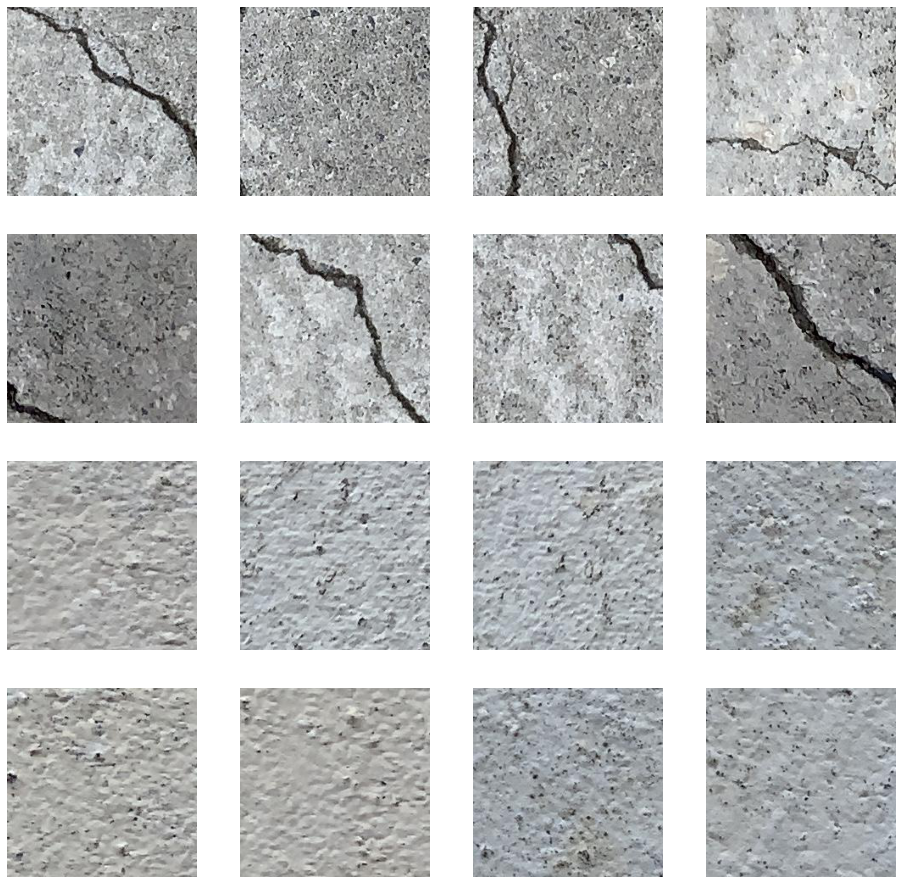

In [12]:
# Set up matplotlib fig, and size it to fit 4x4 pics
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
nrows = 4
ncols = 4

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)
pic_index = 100
train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )


next_cat_pix = [os.path.join(train_cats_dir, fname) 
                for fname in train_cat_fnames[ pic_index-8:pic_index] 
               ]

next_dog_pix = [os.path.join(train_dogs_dir, fname) 
                for fname in train_dog_fnames[ pic_index-8:pic_index]
               ]

for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,rotation_range = 40, width_shift_range = 0.2, height_shift_range = 0.2, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

In [14]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir, batch_size = 20, class_mode = 'binary', target_size = (224, 224))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = test_datagen.flow_from_directory( validation_dir,  batch_size = 20, class_mode = 'binary', target_size = (224, 224))

Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [16]:
# Flatten the output layer to 1 dimension
import tensorflow as tf
from tensorflow.keras import layers

x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(lr=0.0001), loss = 'binary_crossentropy',metrics = ['acc'])

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/rmsprop.py:135: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


In [17]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 100, epochs = 10)

Epoch 1/10
 30/100 [========>.....................] - ETA: 12:47 - loss: 0.9421 - acc: 0.6017

100/100 [==============================] - 442s 4s/step - loss: 0.9421 - acc: 0.6017 - val_loss: 0.7458 - val_acc: 0.5700
